
# Bu soruya cevap arıyoruz: Normalizasyon katmanlarında neden **mean=0, std=1** eğitimi iyileştirir?

Bu notebook’un hedefi şu soruyu **teknik ve temelden derine** cevaplamak:

> **Normalizasyon (özellikle BatchNorm/LayerNorm/GroupNorm) neden aktivasyonları “ortalama 0, standart sapma 1” civarına getirir?**  
> Bu yaklaşım hangi teorik/istatistiksel/sayısal temellere dayanır ve pratikte ne kazandırır?

---

## Yol Haritası

1. Normalizasyonun yaptığı şey (formül)
2. Optimizasyon geometrisi: ölçek problemi ve “condition number”
3. Aktivasyon/gradient akışı: saturasyon ve gradient ölçeği
4. Derin ağlarda varyansın kontrolü: sinyal patlaması/sönmesi
5. BatchNorm’un motivasyonu: dağılımın drift etmesi (katman içi dağılım stabilitesi)
6. Küçük deneyler:  
   - Ölçek farkı → GD/SGD’nin zig-zag yapması  
   - Sigmoid/tanh saturasyonu  
   - Basit MLP’de BN açık/kapalı kıyasının **gradient norm** etkisi



## 1) Normalizasyon ne yapar?

Bir aktivasyon tensörü \(x\) için (batch üzerinden örnek):

\[
\hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}
\]

Burada:
- \(\mu\): ortalama
- \(\sigma^2\): varyans
- \(\epsilon\): sayısal stabilite (0'a bölmeyi engeller)

**BatchNorm** tipik olarak kanallar bazında, batch+spatial üzerinden \(\mu,\sigma\) hesaplar.

Sonra çoğu norm katmanı şu affine dönüşümü ekler:

\[
y = \gamma \hat{x} + \beta
\]

Bu kritik:  
✅ Model temsil gücü kaybolmaz; çünkü \(\gamma,\beta\) ile ağ **istediği ölçeği/ortalaması** geri koyabilir.  
Normalizasyonun amacı “bilgiyi yok etmek” değil, **optimizasyonu kolaylaştırmak**.

---

### 1.1) “mean=0, std=1” niye hedef?

- Ortalama 0: aktivasyonları “merkezler”
- Std 1: ölçeği standartlaştırır

Bu, gradient descent için daha iyi şartlar üretir (aşağıda).



## 2) Optimizasyon Geometrisi: Ölçek farkı neden eğitimi bozar?

Basit bir kuadratik amaç fonksiyonu düşün:

\[
f(\mathbf{w}) = \frac{1}{2}\mathbf{w}^T A \mathbf{w}
\]

Gradient descent yakınsama hızı, \(A\)’nın **condition number**’ına bağlıdır:

\[
\kappa(A) = \frac{\lambda_{\max}}{\lambda_{\min}}
\]

Özellikler (feature’lar) farklı ölçeklerdeyse:
- Hessian kötü koşullu olur (yüksek \(\kappa\))
- Güncelleme **zig-zag** yapar
- Aynı learning rate bazı yönlerde fazla büyük/ küçük kalır

**Std=1 standardizasyonu**, farklı ölçeklerin etkisini azaltır → daha izotropik (daha düzgün) bir optimizasyon yüzeyi.

Aşağıdaki hücrede bunu 2D bir toy problemle görselleştiriyoruz.


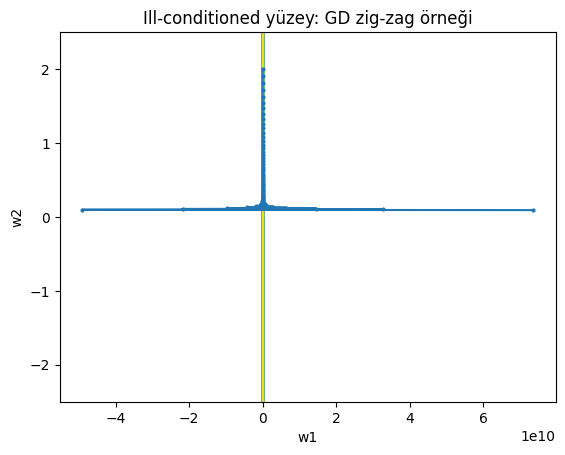

In [1]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Kötü koşullu (ill-conditioned) kuadratik: eksenlerden birinde çok daha "dik"
A = np.array([[50.0, 0.0],
              [0.0, 1.0]])

def grad(w):
    return A @ w

def gd(w0, lr=0.05, steps=60):
    w = w0.copy()
    traj = [w.copy()]
    for _ in range(steps):
        w -= lr * grad(w)
        traj.append(w.copy())
    return np.array(traj)

w0 = np.array([2.0, 2.0])
traj = gd(w0, lr=0.05, steps=60)

# Kontur çizimi
xs = np.linspace(-2.5, 2.5, 200)
ys = np.linspace(-2.5, 2.5, 200)
X, Y = np.meshgrid(xs, ys)
Z = 0.5*(A[0,0]*X**2 + A[1,1]*Y**2)

plt.figure()
plt.contour(X, Y, Z, levels=20)
plt.plot(traj[:,0], traj[:,1], marker="o", markersize=2)
plt.title("Ill-conditioned yüzey: GD zig-zag örneği")
plt.xlabel("w1")
plt.ylabel("w2")
plt.show()



### 2.1) Yorum

Yukarıdaki “zig-zag” davranış **ölçek probleminin** klasik sonucudur:
- Bir eksende çok dik → küçük adım ister
- Diğer eksende daha düz → büyük adım ister

Tek bir LR ile ikisini aynı anda iyi çözmek zor.

Normalizasyon (std≈1) → bu tür ölçek farklarını bastırır → daha stabil ve hızlı eğitim.

> Not: Bu örnek doğrudan “veriyi standardize etmek” gibidir, ama **katman içi normalizasyon** da benzer şekilde ağın içindeki ara temsillerin ölçeğini kontrol eder.



## 3) Aktivasyon & Gradient Akışı: Neden “ortalama 0” iyi?

Birçok aktivasyon fonksiyonu giriş dağılımına hassastır:

- **Sigmoid/Tanh**: büyük |x| değerlerinde **saturasyon** → türev ~0
- **ReLU**: çok negatif tarafta “ölü nöron” riski; çok pozitif tarafta da aktivasyon ölçeği kontrolden çıkabilir

Ortalama 0 civarı, aktivasyonların daha çok “işlevsel aralıkta” kalmasına yardım eder.

Aşağıdaki hücrede sigmoid için saturasyonu görselleştiriyoruz.


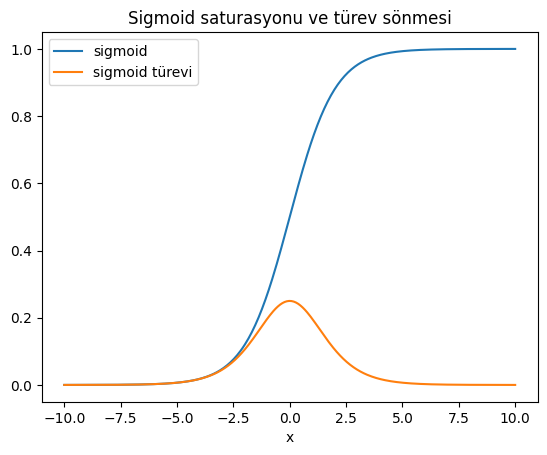

In [2]:

import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 400)
sig = 1 / (1 + np.exp(-x))
dsig = sig * (1 - sig)

plt.figure()
plt.plot(x, sig, label="sigmoid")
plt.plot(x, dsig, label="sigmoid türevi")
plt.title("Sigmoid saturasyonu ve türev sönmesi")
plt.xlabel("x")
plt.legend()
plt.show()


### 3.1) Yorum

Sigmoid türevi en büyükken \(x \approx 0\).  
Eğer katman girişleri sürekli pozitif/negatif tarafa kayarsa → türev sönmeye başlar → gradient akışı zayıflar.

**Mean≈0** bunu azaltma eğilimindedir.

> BN/LN “mutlaka” 0 ortalama yapar diye değil; pratikte aktivasyon dağılımını merkezleyerek saturasyon/ölçek sorunlarını azaltır.



## 4) Derin Ağlarda Varyans Kontrolü: Patlayan/Sönen Sinyal

Derin bir ağda katmanlar ardışık çarpımlar zinciridir.  
Eğer her katmanda aktivasyon ölçeği kontrol edilmezse:

- Aktivasyon varyansı katman katman **büyüyebilir** (patlama)
- veya **küçülebilir** (sönme)

Bu durum:
- sayısal stabiliteyi bozar
- gradientleri patlatır/söndürür
- learning rate seçimini zorlaştırır

Std≈1 hedefi, katmanlar boyunca “enerjiyi” dengede tutmaya yardım eder.

(Ayrıca Xavier/He initialization gibi yöntemler de bu mantıkla tasarlanır.)



## 5) BatchNorm neden “bu şekilde” ortaya çıktı?

BatchNorm’un motivasyonu şudur:
- Eğitim boyunca katman giriş dağılımları kayar (drift eder).
- Bu drift, optimizasyonu zorlaştırır → daha küçük LR, daha uzun eğitim.

BN, her mini-batch’te aktivasyonları normalize ederek bu drift’i azaltır ve genelde:
- daha büyük LR
- daha hızlı yakınsama
- daha stabil eğitim
sağlar.

Ama kritik nüans:
- BN tek faydasını “drift azaltmak”tan almaz.
- BN aynı zamanda **ölçek/gradient** kontrolü ve bir miktar **regularization** etkisi de üretir.



## 6) Mini Deney: Basit MLP’de (BN var/yok) Gradient Norm Karşılaştırması

Aşağıda aynı veri üzerinde iki MLP eğitiyoruz:
- Model A: Normalizasyon yok
- Model B: BatchNorm var

Amaç:  
**Eğitim sırasında gradient normlarının** (ve loss’un) davranışını görmek.

> Not: Bu “kanıt” değil, sezgiyi güçlendiren bir gözlem deneyi.


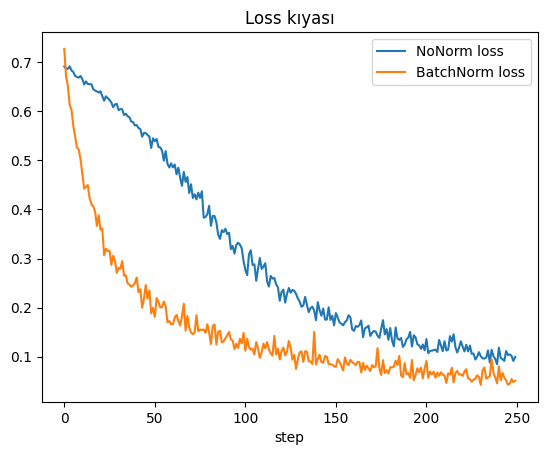

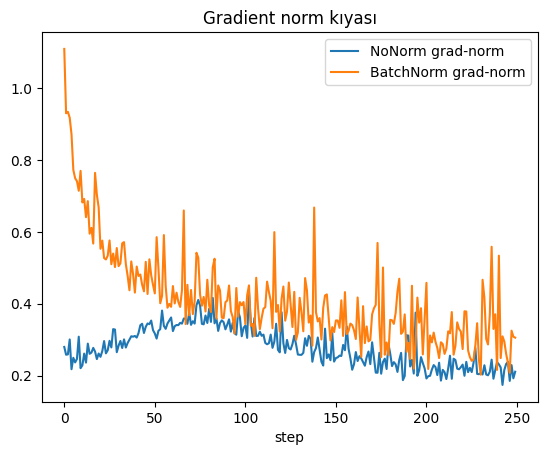

In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

device = "cpu"

# Basit sentetik sınıflandırma verisi
N = 2048
D = 20
X = torch.randn(N, D)
true_w = torch.randn(D, 1)
logits = X @ true_w + 0.2*torch.randn(N, 1)
y = (logits.squeeze() > 0).long()

X, y = X.to(device), y.to(device)

class MLP_NoNorm(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.fc1 = nn.Linear(D, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class MLP_BN(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.fc1 = nn.Linear(D, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 2)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

def train(model, lr=0.05, steps=250, batch_size=256):
    model.to(device)
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    losses, grad_norms = [], []
    for t in range(steps):
        idx = torch.randint(0, N, (batch_size,))
        xb, yb = X[idx], y[idx]
        opt.zero_grad()
        out = model(xb)
        loss = F.cross_entropy(out, yb)
        loss.backward()
        # global grad norm
        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_norm += p.grad.detach().pow(2).sum().item()
        total_norm = total_norm**0.5
        opt.step()
        losses.append(loss.item())
        grad_norms.append(total_norm)
    return np.array(losses), np.array(grad_norms)

loss_a, gn_a = train(MLP_NoNorm(D))
loss_b, gn_b = train(MLP_BN(D))

plt.figure()
plt.plot(loss_a, label="NoNorm loss")
plt.plot(loss_b, label="BatchNorm loss")
plt.title("Loss kıyası")
plt.xlabel("step")
plt.legend()
plt.show()

plt.figure()
plt.plot(gn_a, label="NoNorm grad-norm")
plt.plot(gn_b, label="BatchNorm grad-norm")
plt.title("Gradient norm kıyası")
plt.xlabel("step")
plt.legend()
plt.show()



### 6.1) Yorum

Bu basit deneyde çoğunlukla şunları görürsün:
- BN ile loss daha stabil düşer (özellikle daha yüksek LR’larda daha belirgin olur)
- Gradient normlar daha “kontrollü” davranır

Bu, normalizasyonun pratikte:
- optimizasyonu “kolaylaştırma”
- sayısal stabiliteyi artırma
etkilerinin gözlemsel bir göstergesidir.

> BN’nin etkisi veri, batch size, model ve LR’a göre değişir. Küçük batch’lerde BN bazen sorunlu olur; o zaman GroupNorm/LayerNorm tercih edilir.



## 7) Sonuç: Mean=0, Std=1 hedefinin “dayandığı temel” nedir?

Bu yaklaşım bir “ezber” değil; şu temellere dayanır:

1. **Optimizasyon geometrisi (condition number):**  
   Ölçekleri standardize etmek, daha iyi koşullandırılmış bir problem üretir.

2. **Gradient akışı ve saturasyon:**  
   Ortalama 0 civarı, aktivasyonları etkin türev bölgesinde tutma eğilimindedir.

3. **Sayısal stabilite:**  
   Aktivasyon/gradient büyüklüklerini kontrol etmek taşma/sönmeyi azaltır.

4. **Derin ağlarda sinyal istikrarı:**  
   Katmanlar boyunca varyansı dengede tutmak, derin öğrenmeyi pratikte mümkün kılan şeylerden biridir.

5. **Temsil gücü kaybı yok (γ, β):**  
   Normalizasyon, öğrenmeyi kolaylaştırır; ağ isterse ölçeği/offset’i geri öğrenir.

---

### Pratik mühendislik cümlesi

> “Mean≈0, std≈1” yapmak, ağı daha kolay optimize edilen bir koordinat sistemine taşır.  
> Loss yüzeyini daha düzgün, gradientleri daha kontrollü hale getirir.
